# Predicting Gentrification
*A study into planning application features that can help to signal early warnings of gentrification*
</br></br></br></br>
`Notebook 4`</br>
Author: Mariia Shapovalova</br>
Date: April, 2023

---
## Table of Contents
Notebook 1: Planning Application Dataset Cleaning and EDA
- [0.0 Introduction](#identifier_0)
- [1.0 High Level Overview](#identifier_1)
- [2.0 Initial Feature Selection](#identifier_2)
- 3.0 Infer Missing Census Tracts


---
<center><h2 id="identifier_0">INTRODUCTION</h2><center>

In [1]:
import pandas as pd
import numpy as np

#visualisations
import matplotlib.pyplot as plt
import seaborn as sns

import re
import random
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import OneHotEncoder

# To set up a temporary directory for caching pipeline results
from tempfile import mkdtemp
import tempfile

# To build a pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# To build custom column column transformers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# To do a cross-validated grid search
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
#import custom functions
from functions import *

In [3]:
df=pd.read_csv('../data/clean/merged_df',index_col=0)

In [4]:
overview (df)

The dataframe shape is (701243, 28)


,Data Types,Total Null Values,Null Values Percentage,Sample Value Head,Sample Value Tail,Sample Value
Column_Name,,,,,,
PERMIT_TYPE,object,0,0.0,RENOVATION/ALTERATION,ELECTRIC WIRING,EASY PERMIT PROCESS
REVIEW_TYPE,object,0,0.0,STANDARD PLAN REVIEW,EASY PERMIT WEB,EASY PERMIT
WORK_DESCRIPTION,object,0,0.0,INTERIOR REMODELING OF EXISTING 3 D.U. PER PLA...,INSTALLATION OF (1) 30 AMP DUAL POLE BREAKER A...,"REPLACE DRYWALL, DOORSW, CABINETS & PLUMBING F..."
CONTACT_1_TYPE,object,0,0.0,OWNER AS GENERAL CONTRACTOR,CONTRACTOR-ELECTRICAL,EXPEDITOR
CONTACT_1_CITY,object,0,0.0,CHICAGO,CHICAGO,CHICAGO
CONTACT_1_STATE,object,0,0.0,IL,IL,IL
LOG_PROCESSING_TIME,float64,0,0.0,4.394449,1.791759,0.0
LOG_BUILDING_FEE_PAID,float64,0,0.0,4.828314,3.688879,5.164786
LOG_ZONING_FEE_PAID,float64,0,0.0,4.317488,-23.025851,3.912023


***
<center><h2>Test/Remainder Split<center><h2>

* Test/Validation/Train Splits will be done based on the census tracts (geographies)
* Let's select 20% of the distinct census tracts and separate them in the test dataframe

In [5]:
import random

test_size=0.2

#create a set of distinct census tracts
geo_set=set(df['Census_Tract'])

#measure its length and multiply by the specified test si\e
test_len=int(len(geo_set)*test_size)

random.seed(42)
#select a random subset of distinct census tract of the required size
geo_test=random.sample(list(geo_set),k=test_len)

#create test mask by testing if census tracts belong to the test subset
test_mask=df['Census_Tract'].isin(geo_test)

#apply the mask to generate the test dataset and the inverse to generate remainder dataset
df_test=df[test_mask].reset_index(drop=True)
df_rem=df[~test_mask].reset_index(drop=True)

In [6]:
#check the shapes
print('remained df shape is ', df_rem.shape)
print('test df shape is ', df_test.shape)

remained df shape is  (530398, 28)
test df shape is  (170845, 28)


---
**Dataframge Shape Aim:**
| `Census Tract_Year` | Mean Income Percentage Variation from the City Average (from year x to x+n) : Change Combined | Mean Income in Year x | Numerical X Feature 1 (from year x-t to x)|
| --- | --- | --- | --- |
| 10100_2021 | XXX |XXX |XXX |
| 10100_2020 | XXX |XXX |XXX |
| 10100_2019 | XXX |XXX |XXX |
| --- | --- | --- |--- |

  **Census Tract -- Year -- Median Income for this year**

---
**<center><h3>Baseline Classification Model<center><h3>**

* OHE:
  * Fit & transform on train
  * Transform only on test
  * `All columns are numeric`
* Group by Census Tract & Year
* Determine intial train and prediction windows
  * Baseline model: split at 2013
    * training on 2006 to 2013 data
    * predicting from 2013 to 2021
* Split X and y

---
* **OHE**

In [7]:
ohe_col=list(df_rem.drop(columns='WORK_DESCRIPTION').select_dtypes(include=['object']).columns)
ohe_col

['PERMIT_TYPE',
 'REVIEW_TYPE',
 'CONTACT_1_TYPE',
 'CONTACT_1_CITY',
 'CONTACT_1_STATE']

* Custom Column Transformer: One Hot Encoding that returns a whole dataframe with column names and one hot encoded column dropped

In [8]:
from functions import CustomOneHotEncoder_CT

* `Function Transformer 2`: Grouping by Census Tract and Year
  * based on the year we are making the prediction from and the training length

In [9]:
from functions import df_window_multi_type

* `Custom Transformer 3`: Convert income data into a Binary Target Column calculating if gentrification occured
  * based on the year we are making the prediction from and the prediction length

In [10]:
from functions import comb_change_calc

In [11]:
#let's define this as a separate function that computes the combined metric given two 

def comb_change_calc(start,finish):
    '''
    Use
        Calculates the combined change metric between incomes from two years using the formula: 
        log(abs(abs_change))*(perc_change)
    
    Inputs:
        start (float or int): The initial value (income for the start year - year the prediction is made FROM)
        finish (float or int): The final value (income for the final year - year the prediction is made FOR)
    
    Returns:
        x (float): The combined change metric for two incomes.
    '''
    perc_change=(finish-start)/start
    abs_chage=abs(finish-start)

    if perc_change ==0:
        perc_change=1e-10
    if abs_chage ==0:
        abs_chage=1e-10

    x=np.log(abs_chage)*(perc_change)

    return x

In [12]:
class GentrificationTarget(BaseEstimator, TransformerMixin):
    def __init__(self,year,prediction_period):
        self.year=year
        self.prediction_period=prediction_period
        self.current_income_col=None
        self.future_income_col=None
        self.median_change=None

    def fit(self,df,y=None):

        #name of the column containing income for the current year
        self.current_income_col='Mean_Income_'+str(self.year)

        #the year we are making the prediction for
        prediction_year=self.year+self.prediction_period

        #name of the column containing income for the year we are making the prediction for
        self.future_income_col='Mean_Income_'+str(prediction_year)

        current_income=df[self.current_income_col]
        future_income=df[self.future_income_col]

        combined_change=[comb_change_calc(start,finish) for (start,finish) in zip(current_income,future_income)]

        #fitting in our case is just finding the median change
        self.median_change=np.median(combined_change)
        #returning self with updated attributes that can be accessed in the transform method later
        return self

    def transform(self, df, y=None):
        #this method transforms the existing dataframe to calculate if the change for each geography was more or less than the mean 
        #dropping all the other columns

        df_temp=df.copy()

        current_income=df[self.current_income_col]
        future_income=df[self.future_income_col]

        combined_change=[comb_change_calc(start,finish) for (start,finish) in zip(current_income,future_income)]

        #this is y_target column as a list
        target=[1 if i>self.median_change else 0 for i in combined_change]

        y_col=[col for col in list(df_temp.columns) if bool(re.search('Mean',col))]
        df_temp=df_temp.drop(columns=y_col)
        df_temp['Income']=current_income
        df_temp['Target']=target

        return df_temp

* `Function Transformer 4`: Split X and y columns

In [13]:
def select_columns(df):
    X = df.drop(columns='Target')
    y = df['Target']
    return X, y

***
# MODEL

In [14]:
year=2015
train_period=5
prediction_period=5

X_y_prep_baseline = Pipeline(
    [
    #one hot encoding
    ('ohe', CustomOneHotEncoder_CT()),
    #grouping based on the year we are making the prediction from and the training length
    ('group',FunctionTransformer(df_window_multi_type, kw_args={'year': year, 't': train_period})),
    #convert income change into y_target based on the year we are making the prediction from and the prediction length and drop the remaining of Income columns
    ('target',GentrificationTarget(year,prediction_period)),
    #split into X & y
    ('X_y_split',FunctionTransformer(select_columns))
    ])

In [15]:
model_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),   # data normalization step
    ('regressor', LogisticRegression())   # linear regression model
])

* First, let's fit a model with all the one hot encoded features, without conducting any further feature selection

In [16]:
X_y_prep_baseline.fit(df_rem)
X_rem,y_rem=X_y_prep_baseline.transform(df_rem)
X_test,y_test=X_y_prep_baseline.transform(df_test)

#Initial models not integrating work_desc
X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
X_test=X_test.drop(columns='WORK_DESCRIPTION')

model_pipeline.fit(X_rem,y_rem)
all_features_model=model_pipeline

* Print accuracy for the baseline model with all the features

In [17]:
train_accuracy = all_features_model.score(X_rem, y_rem)
test_accuracy = all_features_model.score(X_test, y_test)

print(f'Baseline model train accuracy is {train_accuracy*100:.2f}%')
print(f'Baseline model test accuracy is {test_accuracy*100:.2f}%')

Baseline model train accuracy is 64.67%
Baseline model test accuracy is 67.61%


* This model contains all the features without conducting any statistical tests

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def conf_matrix(model,X_test):
    y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)

    cf_df = pd.DataFrame(
        cf_matrix, 
        columns=["Predicted No-Gentrification", "Predicted Gentrification"],
        index=["True No-Gentrification", "True Gentrification"]
    )

    display(cf_df)

    tp = cf_matrix[1, 1]
    predicted_gentrification = cf_matrix[:, 1].sum()
    precision = tp/predicted_gentrification
    print(f"Precision = {tp}/{predicted_gentrification} = {round(precision*100, 2)}%")

    true_gentrification = cf_matrix[1, :].sum()
    recall = tp/true_gentrification
    print(f"Recall = {tp}/{true_gentrification} = {round(recall*100, 2)}%")

    # the function expects the estimator, inputs and target as parameters
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

,Predicted No-Gentrification,Predicted Gentrification
True No-Gentrification,50,17
True Gentrification,29,46


Precision = 46/63 = 73.02%
Recall = 46/75 = 61.33%


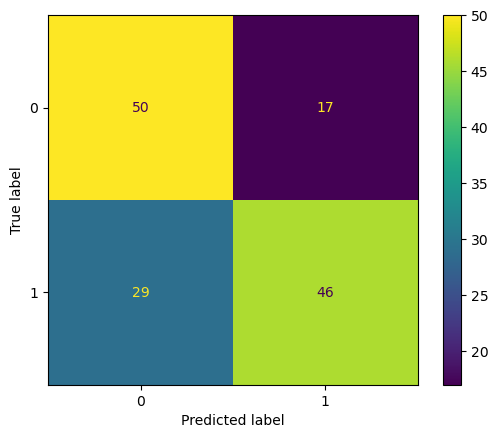

In [19]:
conf_matrix(all_features_model,X_test)

`describe`

* Import outcome of statistic test and multicollinearity explorations

In [20]:
#load the columns to be dropped based on not passing the statistical t-test
columns_to_drop=joblib.load('../data/interim/MODEL_drop_feature_ttest.pkl')

#load dictionary to merge some of the categories together'
merging_categories_di=joblib.load('../data/interim/MODEL_change_cat.pkl')

#multocollinearity
multicol=joblib.load('../data/interim/MODEL_milticol.pkl')

In [21]:
#change some names to merge some ohe together
df_rem_temp=df_rem.replace(merging_categories_di)
df_test_temp=df_test.replace(merging_categories_di)

X_y_prep_baseline.fit(df_rem_temp)
X_rem,y_rem=X_y_prep_baseline.transform(df_rem_temp)
X_test,y_test=X_y_prep_baseline.transform(df_test_temp)

X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
X_test=X_test.drop(columns='WORK_DESCRIPTION')

#drop columns that did not pass t-test
X_rem_ttest=X_rem.drop(columns=columns_to_drop)
X_test_ttest=X_test.drop(columns=columns_to_drop)

model_pipeline.fit(X_rem_ttest,y_rem)
ttest_model=model_pipeline

In [22]:
train_accuracy = ttest_model.score(X_rem_ttest, y_rem)
test_accuracy = ttest_model.score(X_test_ttest, y_test)

print(f'Baseline model train accuracy is {train_accuracy*100:.2f}%')
print(f'Baseline model test accuracy is {test_accuracy*100:.2f}%')

Baseline model train accuracy is 60.11%
Baseline model test accuracy is 57.75%


,Predicted No-Gentrification,Predicted Gentrification
True No-Gentrification,46,21
True Gentrification,39,36


Precision = 36/57 = 63.16%
Recall = 36/75 = 48.0%


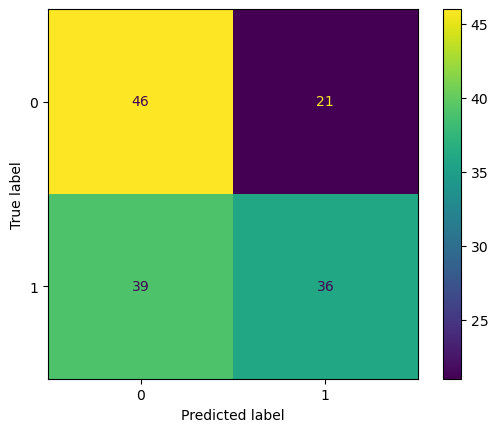

In [23]:
conf_matrix(ttest_model,X_test_ttest)

In [24]:
X_rem_ttest_multicol=X_rem_ttest.drop(columns=multicol)
X_test_ttest_multicol=X_test_ttest.drop(columns=multicol)

model_pipeline.fit(X_rem_ttest_multicol,y_rem)
ttest_multicol_model=model_pipeline

In [25]:
train_accuracy = ttest_multicol_model.score(X_rem_ttest_multicol, y_rem)
test_accuracy = ttest_multicol_model.score(X_test_ttest_multicol, y_test)

print(f'Baseline model train accuracy is {train_accuracy*100:.2f}%')
print(f'Baseline model test accuracy is {test_accuracy*100:.2f}%')

Baseline model train accuracy is 58.88%
Baseline model test accuracy is 59.15%


,Predicted No-Gentrification,Predicted Gentrification
True No-Gentrification,44,23
True Gentrification,35,40


Precision = 40/63 = 63.49%
Recall = 40/75 = 53.33%


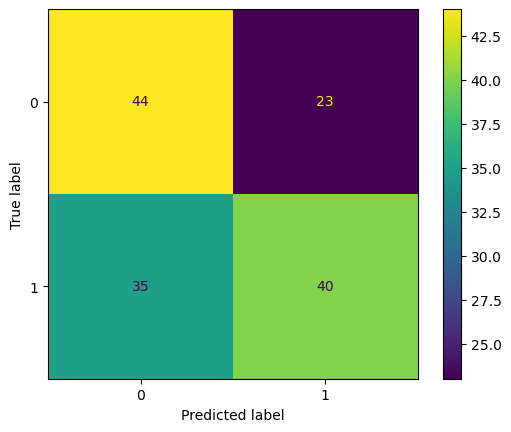

In [26]:
conf_matrix(ttest_multicol_model,X_test_ttest_multicol)

In [27]:
year=2015
train_period=5
prediction_period=5

X_y_prep_baseline = Pipeline(
    [
    #one hot encoding
    ('ohe', CustomOneHotEncoder_CT()),
    #grouping based on the year we are making the prediction from and the training length
    ('group',FunctionTransformer(df_window_multi_type, kw_args={'year': year, 't': train_period})),
    #convert income change into y_target based on the year we are making the prediction from and the prediction length and drop the remaining of Income columns
    ('target',GentrificationTarget(year,prediction_period)),
    #split into X & y
    ('X_y_split',FunctionTransformer(select_columns))
    ])

model_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),   # data normalization step
    ('regressor', LogisticRegression())   # linear regression model
])

X_y_prep_baseline.fit(df_rem)
X_rem,y_rem=X_y_prep_baseline.transform(df_rem)
X_test,y_test=X_y_prep_baseline.transform(df_test)

#Initial models not integrating work_desc
X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
X_test=X_test.drop(columns='WORK_DESCRIPTION')

model_pipeline.fit(X_rem,y_rem)
all_features_model=model_pipeline

train_accuracy = all_features_model.score(X_rem, y_rem)
test_accuracy = all_features_model.score(X_test, y_test)

print(f'Baseline model train accuracy is {train_accuracy*100:.2f}%')
print(f'Baseline model test accuracy is {test_accuracy*100:.2f}%')

Baseline model train accuracy is 64.67%
Baseline model test accuracy is 67.61%


* Model Residuals

In [28]:
y_pred=all_features_model.predict(X_test)

residuals_df=pd.DataFrame()

#tp if y_pred is 1 and y_test is 1
#fp if y_pred is 0 but y_test is 1
#tn if y_pred is 0 and y_test is 0
#fn if y_pred is 1 but y_test is 0

for i in range(len(y_test)):
    if list(y_test)[i] == 1 and y_pred[i] == 1:
        # True positive
        residuals_df.loc[i, 'outcome'] = 'true_positive'
    elif list(y_test)[i] == 0 and y_pred[i] == 1:
        # False positive
        residuals_df.loc[i, 'outcome'] = 'false_positive'
    elif list(y_test)[i] == 0 and y_pred[i] == 0:
        # True negative
        residuals_df.loc[i, 'outcome'] = 'true_negative'
    elif list(y_test)[i] == 1 and y_pred[i] == 0:
        # False negative
        residuals_df.loc[i, 'outcome'] = 'false_negative'

residuals_df=residuals_df.fillna(0)

#add census tracts
residuals_df['Census_Tract']=y_test.index

In [29]:
residuals_df

,outcome,Census_Tract
0,true_negative,10201.0
1,false_negative,10501.0
2,true_negative,10502.0
3,true_positive,10600.0
4,false_positive,10702.0
...,...,...
137,false_positive,841700.0
138,true_positive,842600.0
139,true_positive,842900.0
140,true_positive,843700.0


In [36]:
#Load a dataframe with all the census tracts and their respective coordiantes from the current Permit Dataframe
ct_coord=joblib.load('../data/interim/ct_coord.pkl').reset_index(drop=True)
ct_coord=ct_coord.groupby('CENSUS_TRACT').mean().reset_index()

#add coordinates
residuals_coord_df=coord(residuals_df,ct_coord)

#add household counts
households=df.groupby('Census_Tract')['Household_Count'].mean().reset_index()

residuals_coord_df=residuals_coord_df.merge(households, on='Census_Tract')

In [37]:
import plotly.express as px

outcome=residuals_coord_df['outcome']

fig = px.scatter_mapbox(residuals_coord_df, lat="LATITUDE", lon="LONGITUDE", color='outcome', color_discrete_map={'true_negative': 'green', 'false_positive': 'blue', 'false_negative': 'red', 'true_positive':'orange'}, size='Household_Count',zoom=10, mapbox_style="carto-positron")

fig.update_layout(width=1500,height=1000)

fig.show()

* Run this model with PCA and evaluate PCA coefficients
* Run alternative models


In [38]:
model_pipeline_pca = Pipeline([
    ('scaler', MinMaxScaler()),
    ('dim_reducer', PCA(n_components=1)),
    ('regressor', LogisticRegression())   # linear regression model
])

model_pipeline_pca.fit(X_rem,y_rem)
all_features_model=model_pipeline

train_accuracy = all_features_model.score(X_rem, y_rem)
test_accuracy = all_features_model.score(X_test, y_test)

print(f'Baseline model train accuracy is {train_accuracy*100:.2f}%')
print(f'Baseline model test accuracy is {test_accuracy*100:.2f}%')

Baseline model train accuracy is 56.59%
Baseline model test accuracy is 52.11%


* Running with 1 PCA results in low accuracy

* Run the model without any 'CONTACT_1_CITY','CONTACT_1_STATE' information

In [52]:
df_rem_reduced=df_rem.drop(columns=['CONTACT_1_CITY','CONTACT_1_STATE'])
df_test_reduced=df_test.drop(columns=['CONTACT_1_CITY','CONTACT_1_STATE'])

In [53]:
X_y_prep_baseline.fit(df_rem_reduced)
X_rem,y_rem=X_y_prep_baseline.transform(df_rem_reduced)
X_test,y_test=X_y_prep_baseline.transform(df_test_reduced)

#Initial models not integrating work_desc
X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
X_test=X_test.drop(columns='WORK_DESCRIPTION')

model_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', LogisticRegression())   # linear regression model
])

model_pipeline.fit(X_rem,y_rem)
all_features_model=model_pipeline

train_accuracy = all_features_model.score(X_rem, y_rem)
test_accuracy = all_features_model.score(X_test, y_test)

print(f'Baseline model train accuracy is {train_accuracy*100:.2f}%')
print(f'Baseline model test accuracy is {test_accuracy*100:.2f}%')

Baseline model train accuracy is 63.44%
Baseline model test accuracy is 64.79%


,Predicted No-Gentrification,Predicted Gentrification
True No-Gentrification,48,19
True Gentrification,31,44


Precision = 44/63 = 69.84%
Recall = 44/75 = 58.67%


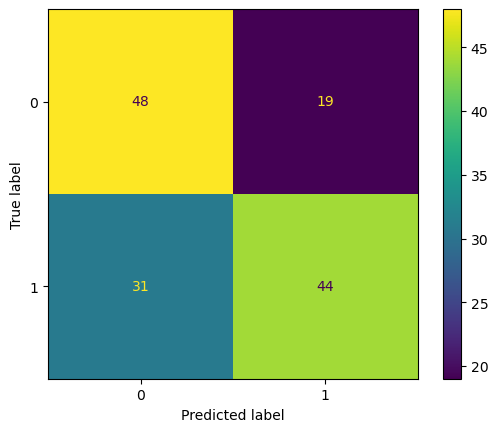

In [54]:
conf_matrix(model_pipeline,X_test)

In [55]:
#one hot
X_y_prep_baseline.fit(df_rem_reduced)
X_rem,y_rem=X_y_prep_baseline.transform(df_rem_reduced)
X_test,y_test=X_y_prep_baseline.transform(df_test_reduced)

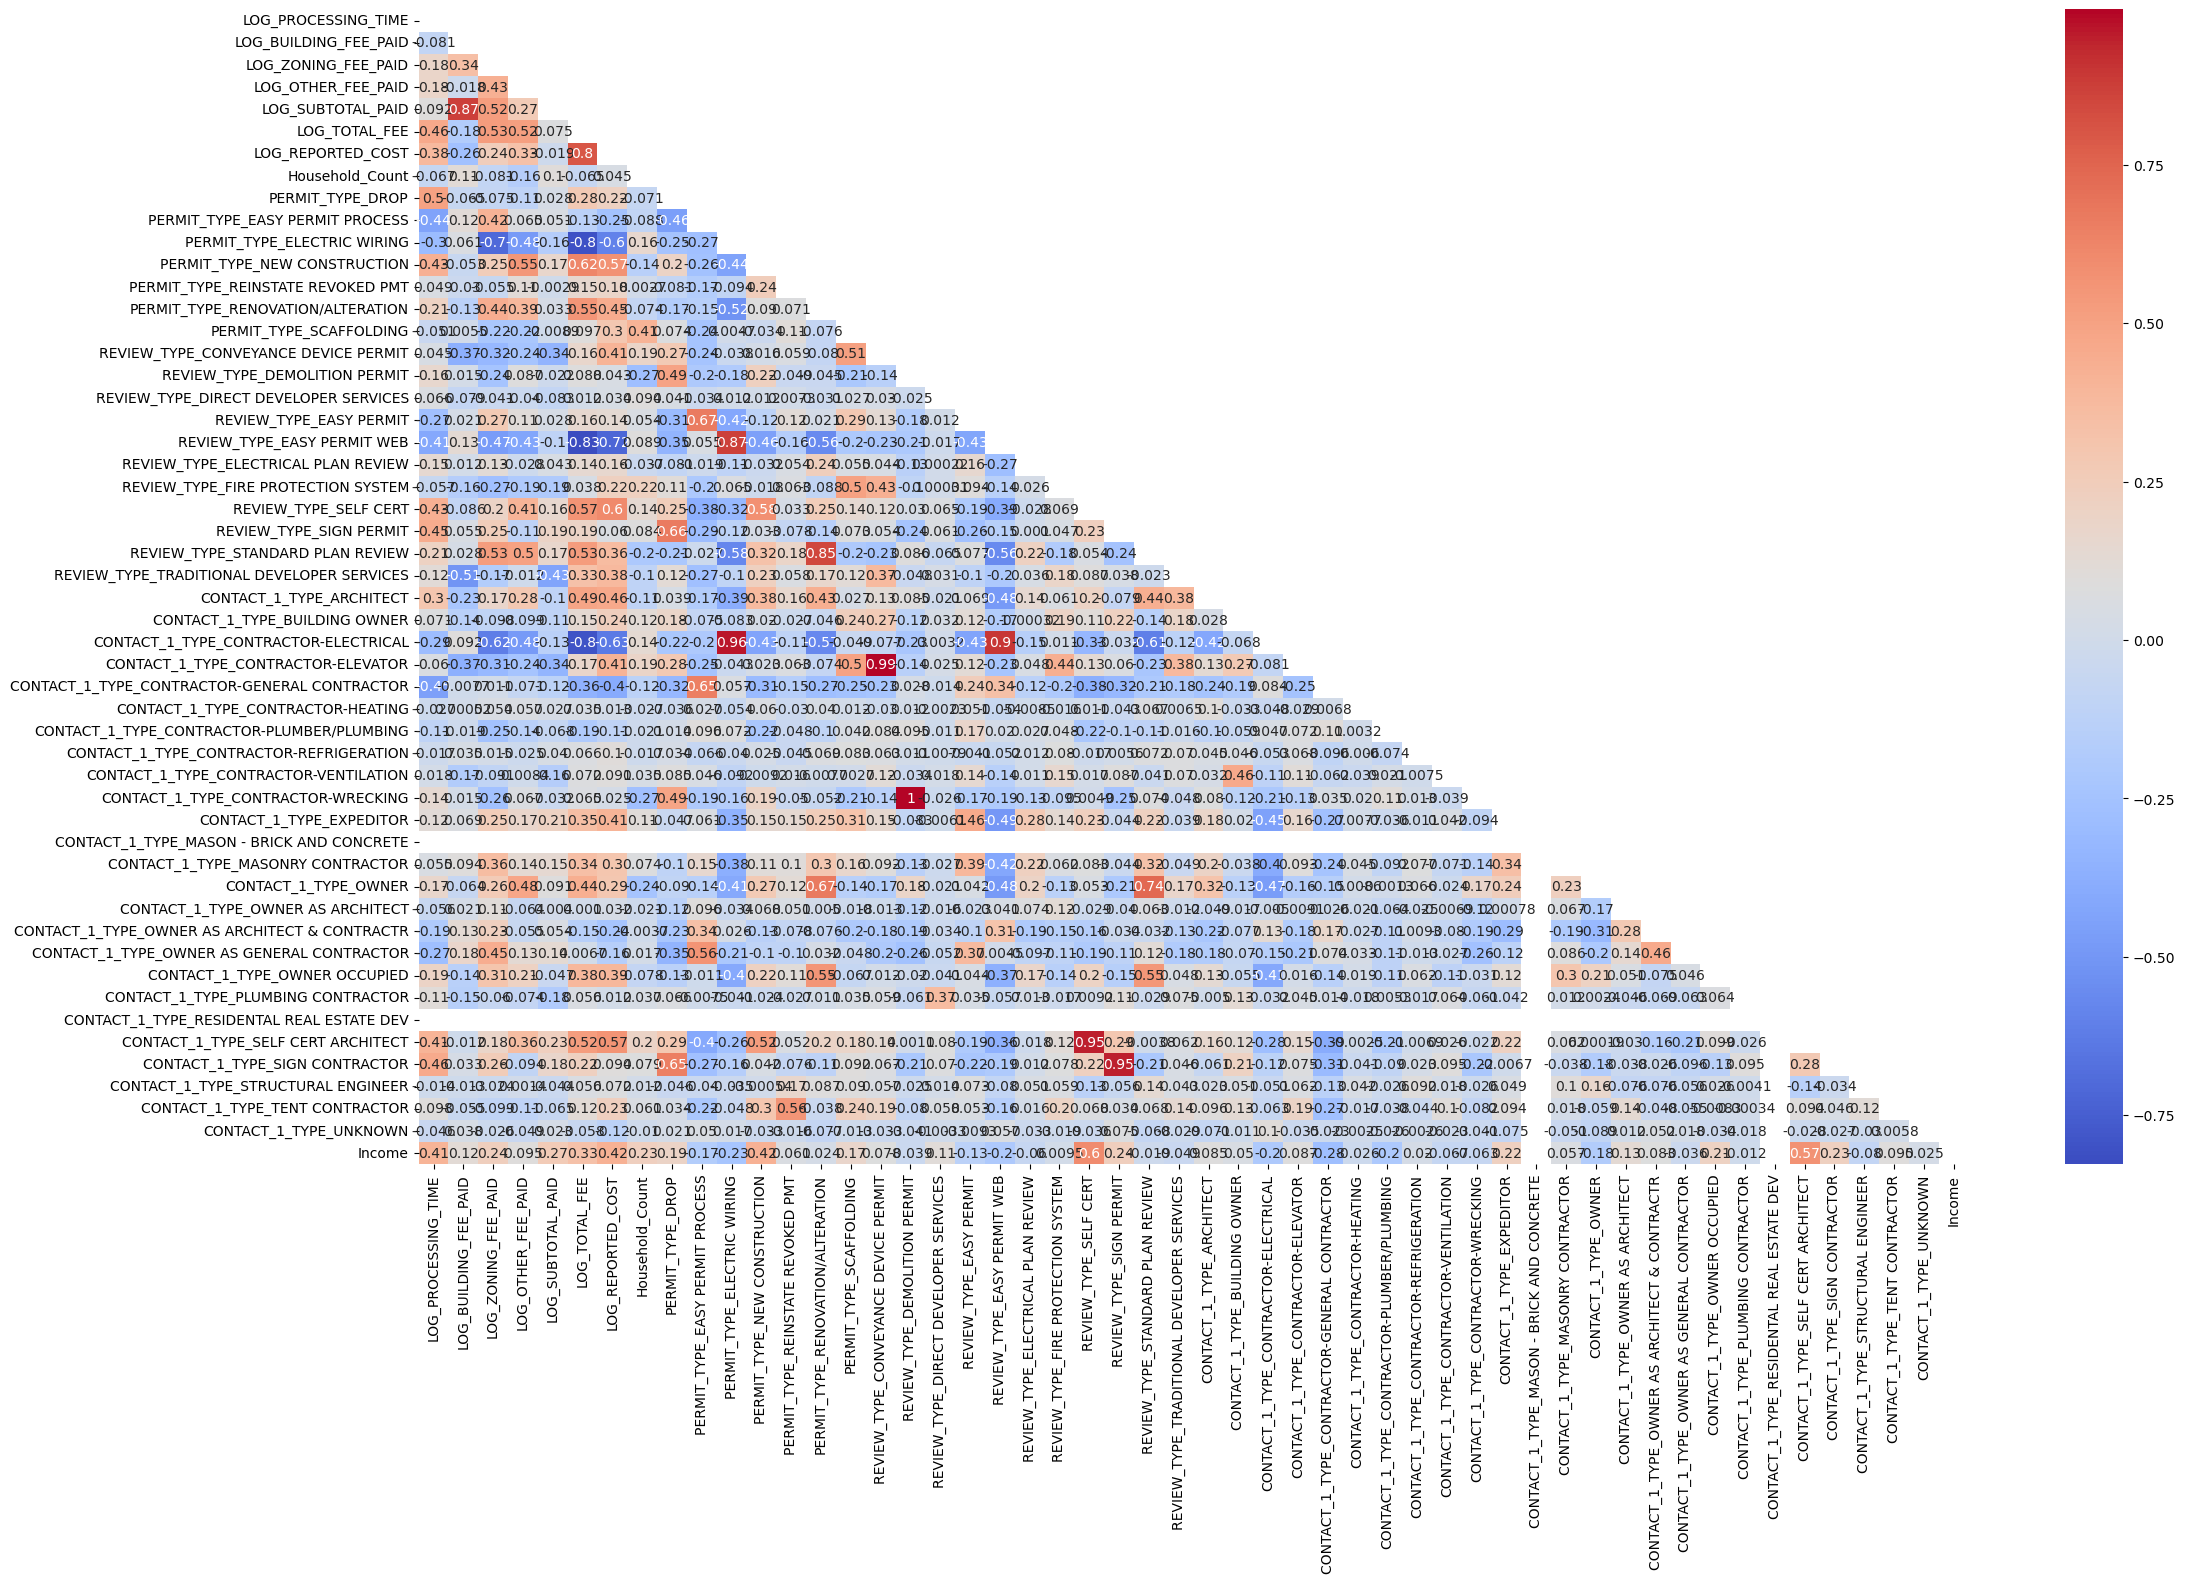

In [48]:
#select dependent variable columns as they should not be part of the multicollinearity testing
col_drop=list(get_columns_with_regex(X_rem,'Mean').columns)

#drop dependent variable columns
df_temp=X_rem.drop(columns=col_drop)

#drop Work Description columns
df_temp=df_temp.drop(columns='WORK_DESCRIPTION')

ind_corr=df_temp.corr()
plt.figure(figsize=(25, 15))
matrix2 = np.triu(ind_corr)
sns.heatmap(ind_corr, annot=True, mask=matrix2, cmap='coolwarm')
plt.show()

***
<center><h3> NLP Model <center><h3>

---
<center><h3>Model Interation: Stacked Model <center><h3>

* Baseline Stacked Model
* Looping through different years
* Gridsearch for stacked model
* 

* Next steps: add a way to concat data given specific train and prediction periods

In [20]:
class GentrificationTarget_Stacked(BaseEstimator, TransformerMixin):
    def __init__(self,training_period,prediction_period):
        self.training_period=training_period
        self.prediction_period=prediction_period
        self.median_change=None

        #the last year we can make the prediction from = 2021 (last year in the income dataset) - prediction windows
        self.year_last_from=2021-self.prediction_period
        #range of years we can predict from. +1 to be inclusive of the last year
        self.year_from_range=range(2010,self.year_last_from+1)

    def fit(self,df,y=None):

        median_di={}

        for year_from in self.year_from_range:
            #only need Median and YEAR columns
            mask=[col for col in list(df.columns) if bool(re.search('Mean',col)) or col in ['Census_Tract','YEAR']]
            df_temp=df_window_multi_type(df[mask],year_from,self.training_period)

            #name of the column containing income for the current year
            current_income_col='Mean_Income_'+str(year_from)
            #the year we are making the prediction for
            prediction_year=year_from+self.prediction_period

            #name of the column containing income for the year we are making the prediction for
            future_income_col='Mean_Income_'+str(prediction_year)

            current_income=df_temp[current_income_col]
            future_income=df_temp[future_income_col]

            combined_change=[comb_change_calc(start,finish) for (start,finish) in zip(current_income,future_income)]

            #for each year create a key:value dictionary pair
            median_di[year_from]=np.median(combined_change)

        #fitting in our case is just finding the mean change
        self.median_changes=median_di
        #returning self with updated attributes that can be accessed in the transform method later
        return self

    def transform(self, df, y=None):
        #this method transforms the existing dataframe to calculate if the change for each geography was more or less than the mean & dropping all the other columns

        #instantiate an empty df for X features
        df_result=pd.DataFrame() 


        #loop for all years less or equal to the last year we can predict from
        for year_from in self.year_from_range:

            #for each loop filter by year, average numeric columns & add concat strings for each year
            df_temp=df_window_multi_type(df,year_from,self.training_period)

            #for each loop determine the year we are predicting for
            prediction_year=year_from+self.prediction_period

            #get income for the year the prediction is made FROM
            current_income_col='Mean_Income_'+str(year_from)
            current_income=df_temp[current_income_col]

            #get income for the year the prediction is made FOR
            future_income=df_temp['Mean_Income_'+str(prediction_year)]

            #calculate change
            combined_change=[comb_change_calc(start,finish) for (start,finish) in zip(current_income,future_income)]
            
            median_temp=self.median_changes[year_from]
            target_temp=[1 if i>median_temp else 0 for i in combined_change]

            #drop all Income columns
            y_col=[col for col in list(df_temp.columns) if bool(re.search('Mean',col))]
            df_temp=df_temp.drop(columns=y_col)

            #add current income column back but rename as Income (otherwise for each loop the name would be different)
            df_temp['Income']=current_income

            #add target column
            df_temp['Target']=target_temp

            #keep concating df_temp to df_result for each loop 
            df_result=pd.concat([df_result,df_temp])

        #separate into X and y
        X = df_result.drop(columns='Target')
        y = df_result['Target']

        return X,y

In [116]:
#define a function to drop columns that did not pass the statistical test
def col_drop(df):
    #ensure the input is 
    df_temp=pd.DataFrame(df)
    new_df=df_temp.drop(columns=columns_to_drop)
    return new_df

In [125]:
cachedir = mkdtemp()

train_period=5
prediction_period=5

X_y_prep_stacked = Pipeline(
    [
    #one hot encoding
    ('ohe', CustomOneHotEncoder_CT()),
    #drop columns that did not pass statistical test,
    #('col_drop',FunctionTransformer(col_drop)),
    #convert income change into y_target based on the year we are making the prediction from and the prediction length and drop the remaining of Income columns
    ('target',GentrificationTarget_Stacked(train_period,prediction_period))
    ],
    memory=cachedir)

In [181]:
model_pipeline_stacked = Pipeline([
    ('scaler', MinMaxScaler()),   # data normalization step
    ('model', LogisticRegression(max_iter=1000))   # linear regression model
])

In [127]:
X_y_prep_stacked.fit(df_rem)
X_rem,y_rem=X_y_prep_stacked.transform(df_rem)
X_test,y_test=X_y_prep_stacked.transform(df_test)

X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
X_test=X_test.drop(columns='WORK_DESCRIPTION')

model_pipeline_stacked.fit(X_rem,y_rem)
accuracy = model_pipeline_stacked.score(X_test, y_test)

In [122]:
print(f'Stacked model accuracy is {accuracy*100:.2f}%')

Stacked model accuracy is 60.74%


In [124]:
model_pipeline.score(X_rem,y_rem)

0.6066350710900474

* Run through all possible combinations of train_period & prediction_period to determine optimal prediction and train windows

`20+ min to run`

In [185]:
'''#loop through each combination of train_period & prediction_period and store test accuracy

#train_period should not exceed 5 years because then predictions from 2010 would not be accurate

import itertools

train_range = [i+1 for i in range(5)]
prediction_range = [i+1 for i in range(11)]

df_results=pd.DataFrame({'train_range':[],'prediction_range':[],'train_score':[],'test_score':[]})


for i, pair in enumerate(itertools.product(train_range, prediction_range)):

    train_period=pair[0]
    prediction_period=pair[1]

    X_y_prep_stacked = Pipeline(
    [('ohe', CustomOneHotEncoder_CT()),
    ('target',GentrificationTarget_Stacked(train_period,prediction_period))],
    memory=cachedir)

    X_y_prep_stacked.fit(df_rem)
    X_rem,y_rem=X_y_prep_stacked.transform(df_rem)
    X_test,y_test=X_y_prep_stacked.transform(df_test)

    X_rem=X_rem.drop(columns='WORK_DESCRIPTION')
    X_test=X_test.drop(columns='WORK_DESCRIPTION')

    model_pipeline_stacked.fit(X_rem,y_rem)

    train_accuracy=model_pipeline_stacked.score(X_rem, y_rem)
    test_accuracy = model_pipeline_stacked.score(X_test, y_test)

    df_results.loc[i] = [train_period, prediction_period, train_accuracy, test_accuracy]'''


In [222]:
#joblib.dump(df_results, '../data/interim/window_optimization.pkl')
df_results=joblib.load('../data/interim/window_optimization.pkl')

In [223]:
df_results.sort_values('test_score',ascending=False)[:10]

,train_range,prediction_range,train_score,test_score
16,2.0,6.0,0.598810,0.637786
27,3.0,6.0,0.617052,0.629280
38,4.0,6.0,0.621354,0.624706
43,4.0,11.0,0.648696,0.624113
54,5.0,11.0,0.648696,0.624113
5,1.0,6.0,0.602112,0.620859
53,5.0,10.0,0.666087,0.620567
49,5.0,6.0,0.622965,0.620164
52,5.0,9.0,0.652199,0.619718
51,5.0,8.0,0.644502,0.613357


* Applying the stacking method allowed to improve the model accuracy from

***
<center><h3>GRID SEARCH FOR STACKED MODEL <center><h3>

* Run a grid search to optimise stacked model

In [189]:
from sklearn.model_selection import GridSearchCV, GroupKFold

* Define custom cross validation split based on the census tracts

In [190]:
# create a custom cross-validation split with 5 folds
geo_groups=X_rem.index
# create a GroupKFold object with 5 folds
gkf = GroupKFold(n_splits=5)

* Sanity Check that unique geometries are being selected

In [191]:
train_li=[]
test_li=[]
for train_index, test_index in gkf.split(X_rem, y_rem, geo_groups):
    # do something with the train and test indices
    train_li.append(train_index)
    train_li.append(test_index)

#set set intersections

* Define pipeline framework

In [195]:
cachedir = mkdtemp()

train_period=3
prediction_period=6

X_y_prep_stacked = Pipeline(
    [
    #one hot encoding
    ('ohe', CustomOneHotEncoder_CT()),
    #drop columns that did not pass statistical test,
    #('col_drop',FunctionTransformer(col_drop)),
    #convert income change into y_target based on the year we are making the prediction from and the prediction length and drop the remaining of Income columns
    ('target',GentrificationTarget_Stacked(train_period,prediction_period))
    ],
    memory=cachedir)

In [196]:
model_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),   # data normalization step
    ('dim_reducer', PCA()), 
    ('model', LogisticRegression(max_iter=1000))   # linear regression model
])

In [197]:
print(X_rem.shape,y_rem.shape)

(575, 63) (575,)


* Define parameters to test in the grid search

In [198]:
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000]

logreg_param_grid = [
    
# l1
    {'scaler': [StandardScaler(),MinMaxScaler()],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [1,2,4,10,0.8,0.9,0.95,None],
    'model': [LogisticRegression(penalty='l1',solver='saga',random_state=22,n_jobs=-1,max_iter=10000)],
    'model__C': c_values,
    'model__solver': ['saga']},
    
# l2
    {'scaler': [StandardScaler(),MinMaxScaler()],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [1,2,4,10,0.8,0.9,0.95,None],
    'model': [LogisticRegression(penalty='l2',random_state=22,n_jobs=-1,max_iter=10000)],
    'model__C': c_values,
    'model__solver': ['lbfgs']}]

* Grid search

In [199]:
# create a custom cross-validation split with 5 folds
geo_groups=X_rem.index
# create a GroupKFold object with 5 folds
gkf = GroupKFold(n_splits=5)

# Instantiate the log reg grid search
logreg_gs = GridSearchCV(
    model_pipeline,
    param_grid=logreg_param_grid,
    cv=gkf.split(X=X_rem, y=y_rem, groups=geo_groups),
    n_jobs=-1,verbose=1,return_train_score=True
    )

* Run the grid search by fitting on X and y remainder

In [200]:
tuned_logreg_gs = logreg_gs.fit(X_rem, y_rem)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


In [201]:
tuned_logreg_gs.best_score_

0.6208695652173912

In [202]:
tuned_logreg_gs.best_params_

{'dim_reducer': PCA(n_components=4),
 'dim_reducer__n_components': 4,
 'model': LogisticRegression(C=1, max_iter=10000, n_jobs=-1, penalty='l1',
                    random_state=22, solver='saga'),
 'model__C': 1,
 'model__solver': 'saga',
 'scaler': MinMaxScaler()}

***
<center><h3>Adding NLP<center><h3>

* First run a NLP model by itself and investigate its residuals

* So far we have been dropping 'Work Description' Column before running the model
* Let's add it to the model

In [233]:
from sklearn.feature_extraction.text import TfidfVectorizer
import string

# import the nltk stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tag import pos_tag 
from nltk.stem import PorterStemmer

STOP_WORDS = stopwords.words('english')
STOP_WORDS.append('per')

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listof_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in STOP_WORDS) & (len(word)>2) & (not bool(re.search('\d', word))):
            #stemmer = PorterStemmer()
            #stemmed_word = stemmer.stem(word)
            #listof_words.append(stemmed_word)
            listof_words.append(word)
        else:
            continue

    return listof_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\44742\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [236]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

class Description_Vector(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = TfidfVectorizer(tokenizer=my_tokenizer,min_df=0.05, max_df=0.8)
        
    def fit(self, df, y=None):
        description=df[0]['WORK_DESCRIPTION']
        self.vectorizer.fit(description)
        return self
        
    def transform(self, df, y=None):
        '''
        This methos vectorizers one columnn but returns the whole dataframe
        '''
        description=df[0]['WORK_DESCRIPTION']
        description_transformed = self.vectorizer.transform(description)
        feature_names=self.vectorizer.get_feature_names_out()
        df_vect=pd.DataFrame(description_transformed.toarray(), columns=feature_names)
        X=pd.concat([df[0].reset_index(drop=True),df_vect.reset_index(drop=True)],axis=1).drop(columns='WORK_DESCRIPTION')
        y=df[1].reset_index(drop=True)
        return X,y

In [237]:
cachedir = mkdtemp()

train_period=5
prediction_period=5

X_y_prep_new = Pipeline(
    [
    #one hot encoding
    ('ohe', CustomOneHotEncoder_CT()),
    #drop columns that did not pass statistical test,
    #convert income change into y_target based on the year we are making the prediction from and the prediction length and drop the remaining of Income columns
    ('target',GentrificationTarget_Stacked(train_period,prediction_period)),
    ('vector',Description_Vector()),
    ],
    memory=cachedir)

In [238]:
X_y_prep_new.fit(df_rem)
X_rem,y_rem=X_y_prep_new.transform(df_rem)
X_test,y_test=X_y_prep_new.transform(df_test)

In [239]:
model_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),   # data normalization step
    ('model', LogisticRegression(max_iter=1000))   # linear regression model
])

In [240]:
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000]

logreg_param_grid = [
    
    
# l2
    {'scaler': [MinMaxScaler()],
    'dim_reducer': [PCA()],
    'dim_reducer__n_components': [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,None],
    'model': [LogisticRegression(penalty='l2',random_state=22,n_jobs=-1,max_iter=10000)],
    'model__C': c_values,
    'model__solver': ['lbfgs']}]

In [241]:
model_pipeline.fit(X_rem,y_rem)
accuracy = model_pipeline.score(X_test, y_test)
print(accuracy)

0.5481927710843374


---
***Residuals***

In [41]:
def drop_column_if_present(df, column_name):
    if column_name in df.columns:
        df.drop(column_name, axis=1, inplace=True)